# <font color=green> Aubrey Bagdonas and Martin Manion 
    Spr22_MIS_3080_001

In [1]:
#Tuned Neural Network with all data, then tuned network without ESG data

In [2]:
##IMPORTS

In [3]:
#see that Tensorflow is installed
#!pip install tensorflow -q

In [4]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

#tensorflow imports
import tensorflow as tf
from tensorflow import keras

#sklearn imports
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config

In [5]:
##DEFINTIONS

In [6]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file, sourcePath, compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [7]:
#function provided that plots the learning curve for neural networks
def nn_plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()

In [8]:
#function to plot actual values vs. predicted values
def plot_actual_pred( actual, prediction ):
    plt.plot(actual, ".-", alpha=.6, label="Actual")
    plt.plot(prediction, ".-", alpha=.6, label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

In [9]:
#function to plot a series as well as the predicted and value to be predicted (if known)
def plot_series(series, y=None, y_pred=None):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(range(series.shape[0], series.shape[0]+y.shape[0]), y, "bx-", markersize=10, label="Actual")
    if y_pred is not None:
        plt.plot(range(series.shape[0], series.shape[0]+y_pred.shape[0]), y_pred, "ro-", label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

In [10]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [11]:
##SOURCE THE DATA

In [12]:
df = pd.read_csv("ESG_Bond_Clean.csv")

In [13]:
df

,recordID,IssuerName,BBPwr,ESGrating,EnergyIntensity_Sales,WasteGenerated_Sales,CO2EmissionsPerSales,PercentWmnBoard,Cpn,Series,...,MtyType,Currency,260D_Volatility,Debt_EBITDA,FCF_TotDbt,FitchRating,MoodyRtg,SP_Rating,YldToMtyAsk,Days2Maturity
0,1,Country Garden Holdings Co Ltd,2.50,B,1.82,0.01,0.72,15.39,8.000,,...,CALLABLE,USD,50.196,5.07,0.040,BBB-,Missing,Missing,22.799,635.0
1,2,SSE PLC,2.91,AAA,4032.32,0.34,1118.28,40.00,4.000,,...,PERP/CALL,EUR,NaN,2.19,0.060,BBB-,Baa3,BBB-,4.091,NaN
2,3,Cooperatieve Rabobank UA,3.04,N.S.,6.72,0.01,2.85,33.33,4.875,,...,PERP/CALL,EUR,NaN,NaN,NaN,BBB,Baa3,Missing,5.304,NaN
3,4,Gazprom PJSC Via Gaz Capital SA,1.77,N.S.,147.64,0.51,35.12,NaN,2.250,,...,AT MATURITY,CHF,82.183,1.62,0.120,WD,WR,NR,1145.480,78.0
4,5,Broadcom Inc,2.18,BB,17.98,0.45,10.65,33.33,4.926,144A,...,CALLABLE,USD,NaN,2.53,0.347,BBB-,Baa3,Missing,5.575,5492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,A2A SpA,2.45,N.S.,4413.06,116.40,894.25,41.67,0.625,EMTN,...,CALLABLE,EUR,NaN,3.82,0.135,Missing,Baa2,BBB,2.499,3361.0
4996,4997,Cooperatieve Rabobank UA,3.04,N.S.,6.72,0.01,2.85,33.33,0.010,EMTN,...,AT MATURITY,EUR,4.914,NaN,NaN,Missing,Aaa,Missing,1.471,2983.0
4997,4998,Lloyds Banking Group PLC,2.91,AA,22.17,0.29,5.07,40.00,1.750,EMTN,...,CALLABLE,EUR,0.985,NaN,NaN,BBB+,A3,BBB-,2.455,2320.0
4998,4999,Volkswagen Group of America Finance LLC,2.69,N.S.,87.85,9.98,28.62,35.00,3.200,144A,...,AT MATURITY,USD,3.878,4.58,0.100,Missing,A3,BBB+,3.966,1608.0


array([[<AxesSubplot:title={'center':'recordID'}>,
        <AxesSubplot:title={'center':'BBPwr'}>,
        <AxesSubplot:title={'center':'EnergyIntensity_Sales'}>],
       [<AxesSubplot:title={'center':'WasteGenerated_Sales'}>,
        <AxesSubplot:title={'center':'CO2EmissionsPerSales'}>,
        <AxesSubplot:title={'center':'PercentWmnBoard'}>],
       [<AxesSubplot:title={'center':'Cpn'}>,
        <AxesSubplot:title={'center':'260D_Volatility'}>,
        <AxesSubplot:title={'center':'Debt_EBITDA'}>],
       [<AxesSubplot:title={'center':'FCF_TotDbt'}>,
        <AxesSubplot:title={'center':'YldToMtyAsk'}>,
        <AxesSubplot:title={'center':'Days2Maturity'}>]], dtype=object)

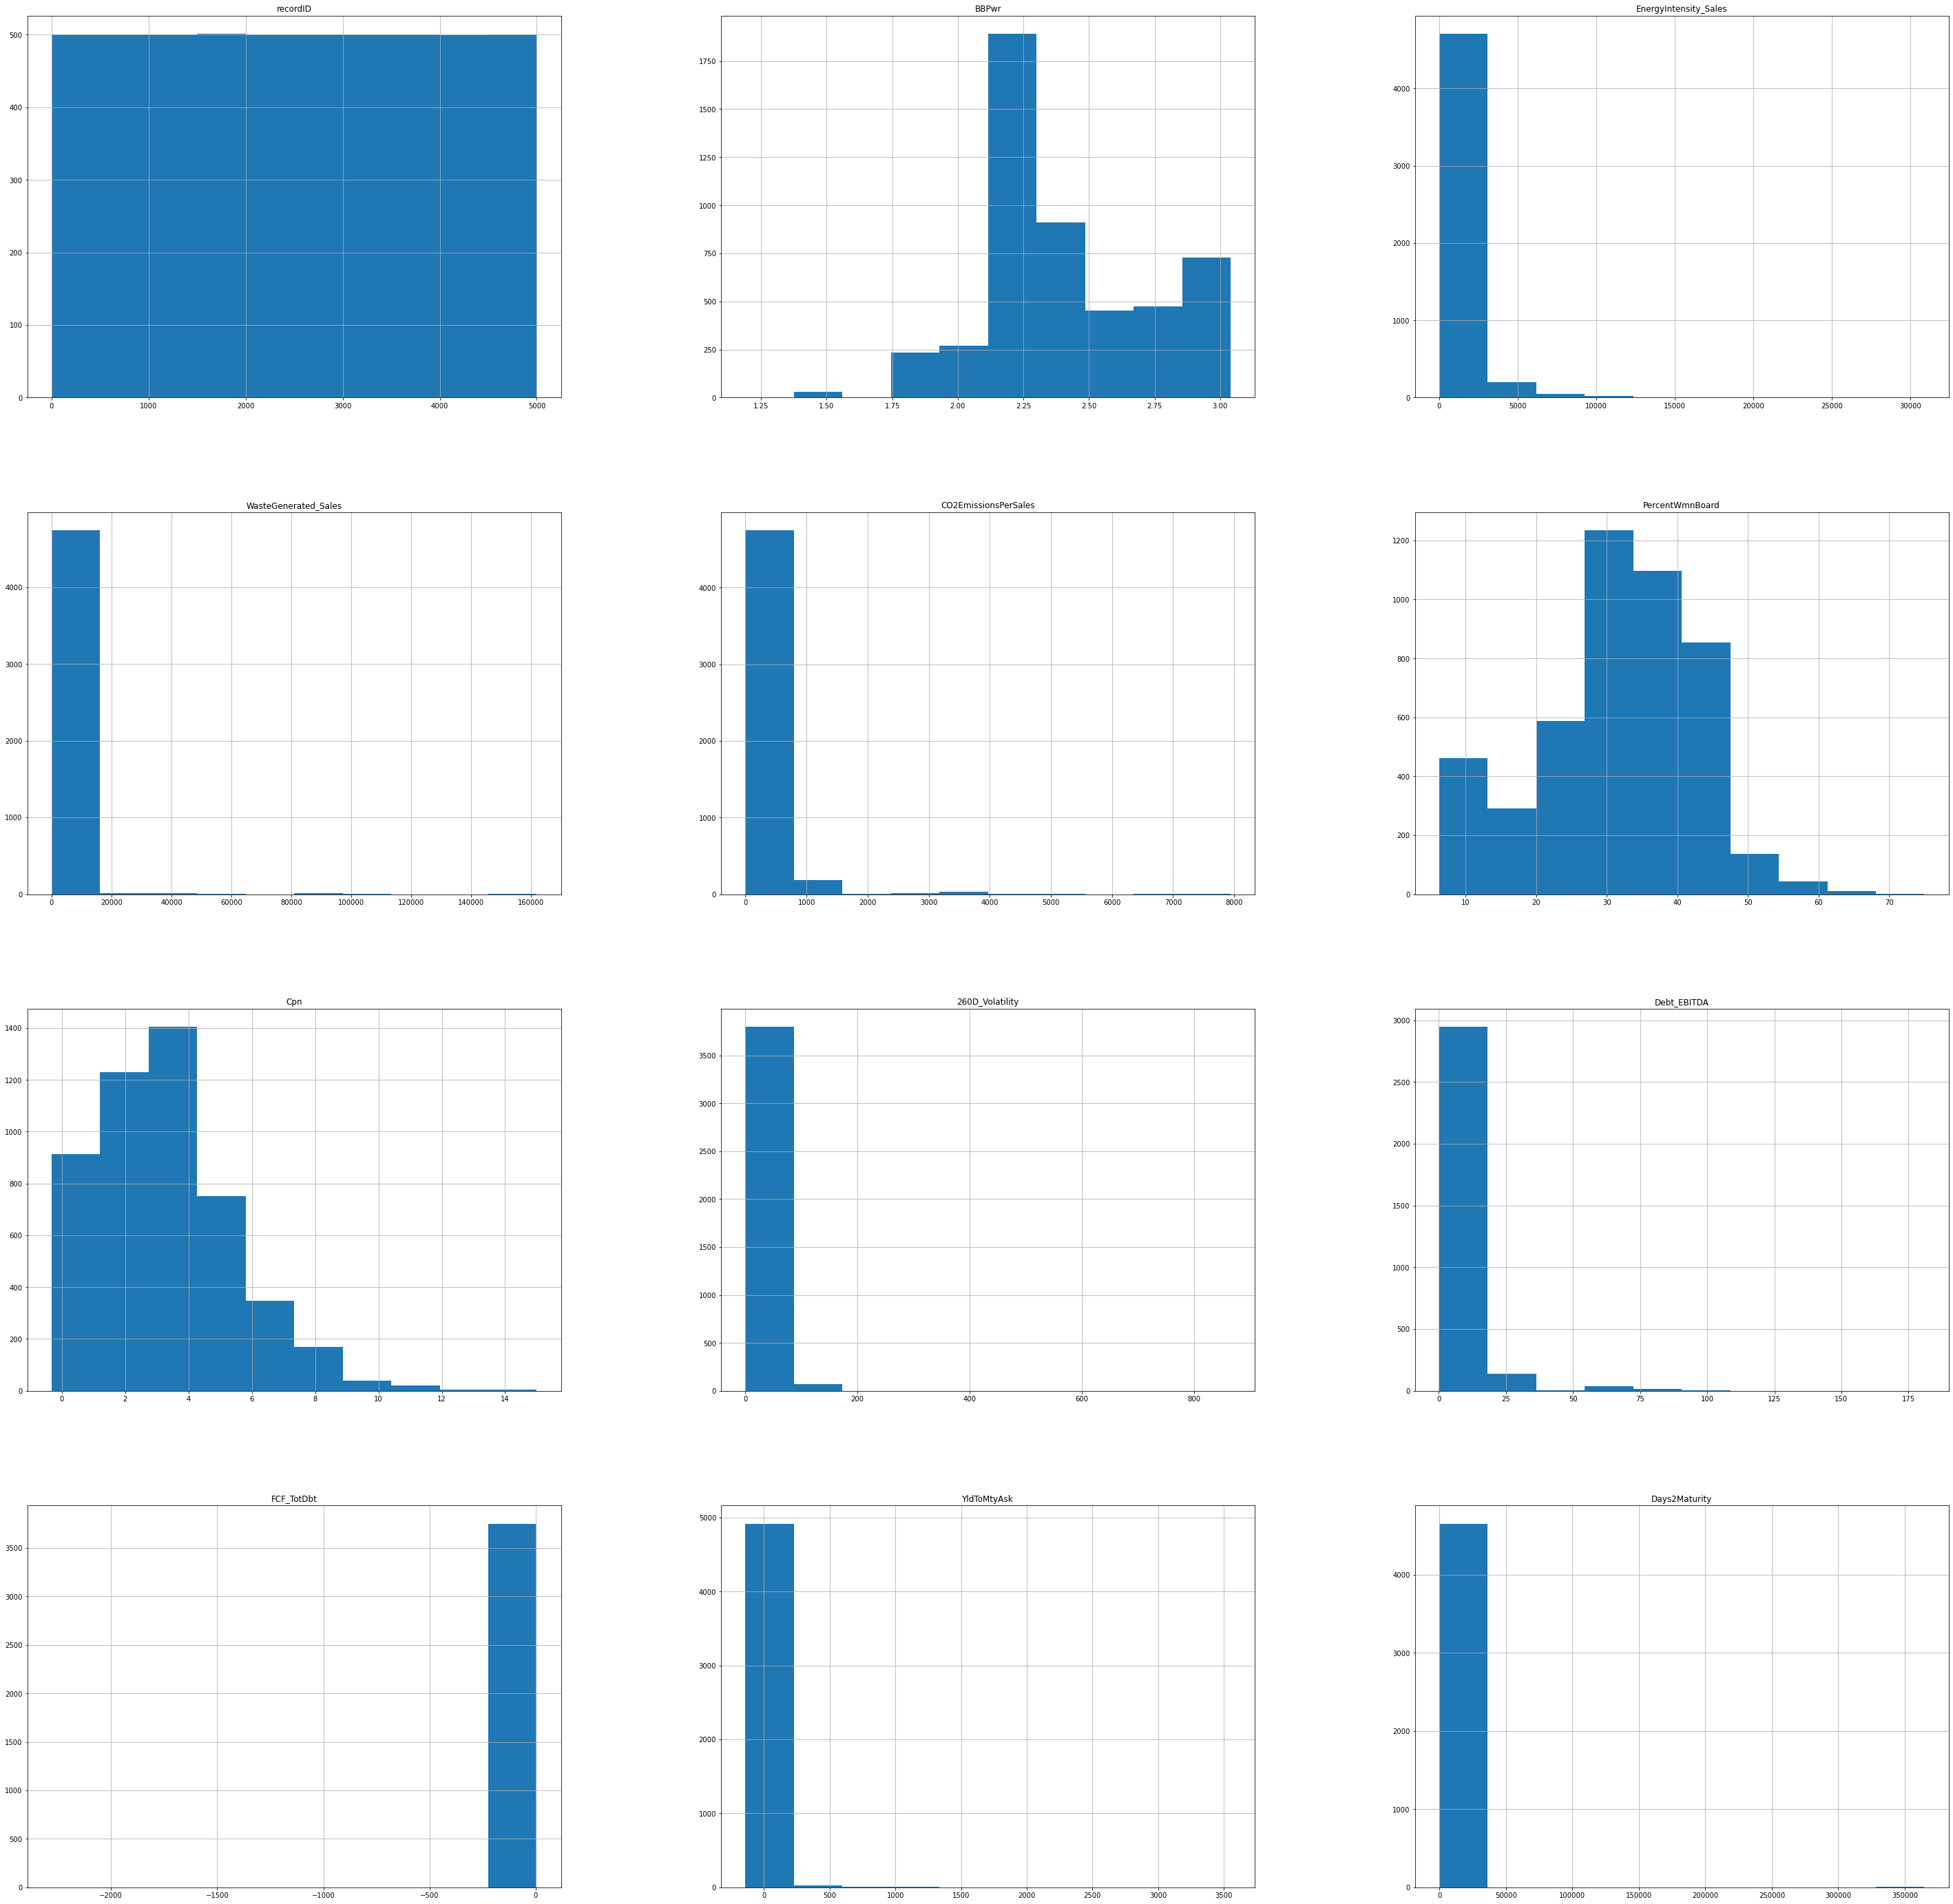

In [14]:
df.hist(figsize=(50,50))

In [15]:
df.corr()

,recordID,BBPwr,EnergyIntensity_Sales,WasteGenerated_Sales,CO2EmissionsPerSales,PercentWmnBoard,Cpn,260D_Volatility,Debt_EBITDA,FCF_TotDbt,YldToMtyAsk,Days2Maturity
recordID,1.000000,0.014068,-0.035618,-0.002653,-0.027922,0.141842,-0.264816,-0.188125,-0.028950,-0.009128,-0.080243,-0.029984
BBPwr,0.014068,1.000000,-0.054288,-0.058961,-0.082043,0.234646,-0.104296,-0.090322,-0.060100,0.008160,-0.004447,0.056671
EnergyIntensity_Sales,-0.035618,-0.054288,1.000000,0.099838,0.613353,-0.094226,0.069991,0.080961,0.062607,0.000287,0.008432,-0.000515
WasteGenerated_Sales,-0.002653,-0.058961,0.099838,1.000000,0.086979,-0.071320,0.088967,0.036551,-0.063208,0.002793,-0.001772,0.005257
CO2EmissionsPerSales,-0.027922,-0.082043,0.613353,0.086979,1.000000,-0.102612,0.089644,0.032890,0.053313,0.005033,-0.009680,0.004814
PercentWmnBoard,0.141842,0.234646,-0.094226,-0.071320,-0.102612,1.000000,-0.245442,-0.181919,-0.107401,-0.023023,-0.113996,-0.001362
Cpn,-0.264816,-0.104296,0.069991,0.088967,0.089644,-0.245442,1.000000,0.282525,0.066344,-0.000730,0.211279,0.036949
260D_Volatility,-0.188125,-0.090322,0.080961,0.036551,0.032890,-0.181919,0.282525,1.000000,0.087470,0.021776,0.320213,-0.008738
Debt_EBITDA,-0.028950,-0.060100,0.062607,-0.063208,0.053313,-0.107401,0.066344,0.087470,1.000000,-0.250856,0.099544,-0.037893
FCF_TotDbt,-0.009128,0.008160,0.000287,0.002793,0.005033,-0.023023,-0.000730,0.021776,-0.250856,1.000000,0.001505,0.001476


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   recordID               5000 non-null   int64  
 1   IssuerName             5000 non-null   object 
 2   BBPwr                  5000 non-null   float64
 3   ESGrating              5000 non-null   object 
 4   EnergyIntensity_Sales  4993 non-null   float64
 5   WasteGenerated_Sales   4781 non-null   float64
 6   CO2EmissionsPerSales   4997 non-null   float64
 7   PercentWmnBoard        4720 non-null   float64
 8   Cpn                    4883 non-null   float64
 9   Series                 5000 non-null   object 
 10  BBG_Composite          5000 non-null   object 
 11  MtyType                5000 non-null   object 
 12  Currency               5000 non-null   object 
 13  260D_Volatility        3870 non-null   float64
 14  Debt_EBITDA            3141 non-null   float64
 15  FCF_

<function matplotlib.pyplot.show(close=None, block=None)>

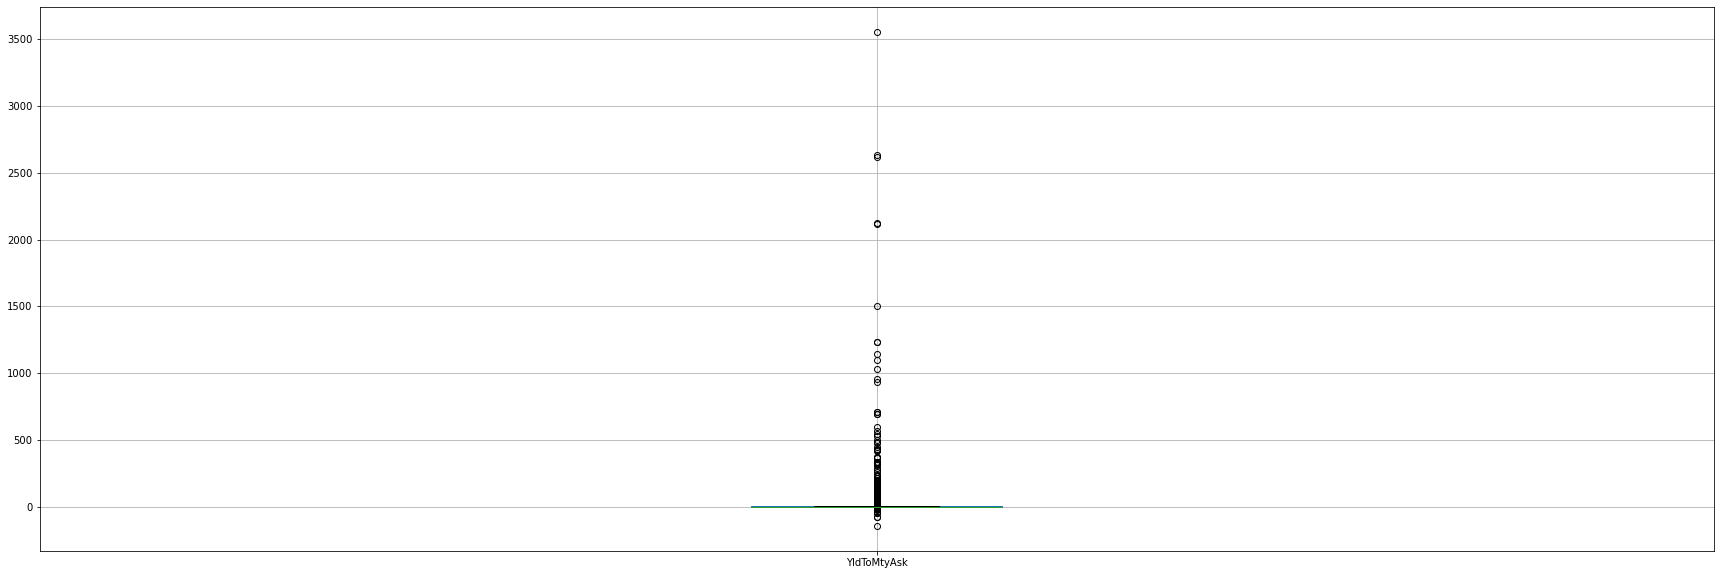

In [17]:
df.boxplot(column = ['YldToMtyAsk'], figsize = (30,10))
plt.show

In [18]:
df['YldToMtyAsk'].sort_values(ascending=False)

2077    3551.87
1128    2633.87
2303    2618.24
333     2126.33
1058    2116.80
         ...   
4776        NaN
4915        NaN
4923        NaN
4953        NaN
4969        NaN
Name: YldToMtyAsk, Length: 5000, dtype: float64

In [19]:
df = df[ df['YldToMtyAsk'] < 100]

In [20]:
df = df[ df['YldToMtyAsk'] > 0]

In [21]:
df.drop(columns=["recordID", "IssuerName", "Series"], inplace=True)

In [22]:
df.dropna( subset=['YldToMtyAsk'], inplace=True )

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4717 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BBPwr                  4717 non-null   float64
 1   ESGrating              4717 non-null   object 
 2   EnergyIntensity_Sales  4710 non-null   float64
 3   WasteGenerated_Sales   4517 non-null   float64
 4   CO2EmissionsPerSales   4714 non-null   float64
 5   PercentWmnBoard        4470 non-null   float64
 6   Cpn                    4650 non-null   float64
 7   BBG_Composite          4717 non-null   object 
 8   MtyType                4717 non-null   object 
 9   Currency               4717 non-null   object 
 10  260D_Volatility        3647 non-null   float64
 11  Debt_EBITDA            2955 non-null   float64
 12  FCF_TotDbt             3531 non-null   float64
 13  FitchRating            4717 non-null   object 
 14  MoodyRtg               4717 non-null   object 
 15  SP_R

### <font color = green> PICKLE

In [24]:
#define directory
DOWNLOAD_DIR = "C:/Users/mtman/Desktop/Junior Spring/MIS 3080"

#create the pickle file
pickleFile = open(DOWNLOAD_DIR + "/FinalData.pk1","wb")


#X_instance = pickle.load(pickleFile)
pickle.dump(df, pickleFile)

pickleFile.close()

In [25]:
## DATA PREP

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['YldToMtyAsk']), 
    df.YldToMtyAsk, 
    test_size=.2, 
    random_state=32
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3773, 17), (3773,), (944, 17), (944,))

In [27]:
#look at the first 5 games in the Test data set (will predict later on)
print(X_test[0:5])
print(y_test[0:5])

      BBPwr ESGrating  EnergyIntensity_Sales  WasteGenerated_Sales  \
820    2.18      N.S.                 740.54                 20.23   
1174   2.55        BB                  10.05                  0.01   
4311   2.40      N.S.                 101.96                  7.32   
3645   2.69      N.S.                  58.23                  7.46   
3344   2.91      N.S.                  16.17                  0.30   

      CO2EmissionsPerSales  PercentWmnBoard    Cpn BBG_Composite      MtyType  \
820                 239.09            22.22  5.750            B+     CALLABLE   
1174                  2.38              NaN  4.625          BBB-  AT MATURITY   
4311                 38.63            40.00    NaN            NR    PERP/CALL   
3645                 18.91            33.33  3.150             A     CALLABLE   
3344                  6.72            45.45  3.500          BBB+     CALLABLE   

     Currency  260D_Volatility  Debt_EBITDA  FCF_TotDbt FitchRating MoodyRtg  \
820       US

In [28]:
df['MoodyRtg'].value_counts()

Missing    947
Baa1       683
Baa2       639
Baa3       448
A3         423
A2         365
Aa3        204
A1         192
Ba1        134
Ba2        117
Aaa        102
Ba3         94
Aa2         78
WR          67
B1          49
B2          47
B3          34
NR          24
Aa1         22
Caa1        18
Caa3        17
Caa2         7
C            6
Name: MoodyRtg, dtype: int64

In [29]:
#Pipeline
cat_attribs = ["BBG_Composite", "MtyType", "Currency"]

ord_attribs = ['ESGrating', "FitchRating", "MoodyRtg", "SP_Rating"]

esg_ord = ['N.S.', 'CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']

fitch_ord = ['Missing', 'WD', 'NR', 'C', 'CC', 'CCC', 'B-', 'B', 'B+',
            'BB-', 'BB', 'BB+', 'BBB-', 'BBB','BBB+','A-','A','A+',
            'AA-','AA','AA+','AAA-','AAA','AAA+']

moody_ord = ['Missing', 'WR', 'NR', 'C', 'Ca','Caa3','Caa2','Caa1',
             'B3','B2','B1','Ba3','Ba2','Ba1','Baa3','Baa2','Baa1',
             'A3','A2','A1','Aa3','Aa2','Aa1','Aaa']

sp_ord = ['Missing', 'NR', 'D', 'CCC-', 'CCC', 'CCC+','B-', 'B', 'B+', 
          'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+', 'AA-', 'AA', 'AAA']

ord_mappings = [esg_ord] + [fitch_ord] + [moody_ord] + [sp_ord]

#set the numerical attributes
num_attribs = list( X_train.drop(columns=cat_attribs+ord_attribs,axis=1) )

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled using MinMaxScaler (preferred for neural networks)
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), 
 ('std_scaler', MinMaxScaler()),   
])

ord_pipeline = Pipeline( [
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('ord', OrdinalEncoder(categories=ord_mappings))
])
#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('ord', ord_pipeline, ord_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

In [30]:
#create an array of prepared data based on the training data set and the Pipeline process defined above
X_train = full_pipeline.fit_transform( X_train)
X_test = full_pipeline.transform( X_test )

X_train.shape, X_test.shape

((3773, 72), (944, 72))

In [31]:
#scale the Y data
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test = yscaler.transform(np.array(y_test).reshape(-1,1))

In [32]:
##BASELINE

In [33]:
#predcition is based on mean value
baseline_prediction = yscaler.inverse_transform( y_test.mean().reshape(-1,1)) 

#populate an array with the baseline prediction value
predictions = np.full(shape=y_test.shape[0], fill_value = baseline_prediction)

#unscale predicted values
actual= yscaler.inverse_transform( y_test )

#calculate the root mean square error between the prediction and the actual
naive = mean_squared_error(predictions, actual, squared=False)
print( 'Naive ERROR: {:,.2f}'.format(naive) )

Naive ERROR: 7.38


### <font color=green>MODEL THREE - NEURAL NET, ESG FEATURES EXCLUDED

In [45]:
early_stopping = keras.callbacks.EarlyStopping(
patience = 2,
mode='min',
monitor='val_loss'
)

In [34]:
df2 = df.drop(columns = ['MtyType','Currency','Cpn','260D_Volatility','Debt_EBITDA','FCF_TotDbt'])

In [35]:
df2

,BBPwr,ESGrating,EnergyIntensity_Sales,WasteGenerated_Sales,CO2EmissionsPerSales,PercentWmnBoard,BBG_Composite,FitchRating,MoodyRtg,SP_Rating,YldToMtyAsk,Days2Maturity
0,2.50,B,1.82,0.01,0.72,15.39,NR,BBB-,Missing,Missing,22.799,635.0
1,2.91,AAA,4032.32,0.34,1118.28,40.00,BBB-,BBB-,Baa3,BBB-,4.091,NaN
2,3.04,N.S.,6.72,0.01,2.85,33.33,BBB-,BBB,Baa3,Missing,5.304,NaN
4,2.18,BB,17.98,0.45,10.65,33.33,BBB-,BBB-,Baa3,Missing,5.575,5492.0
5,2.69,N.S.,284.76,508.58,81.87,12.50,NR,Missing,Missing,B-,8.470,2449.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.45,N.S.,4413.06,116.40,894.25,41.67,BBB,Missing,Baa2,BBB,2.499,3361.0
4996,3.04,N.S.,6.72,0.01,2.85,33.33,NR,Missing,Aaa,Missing,1.471,2983.0
4997,2.91,AA,22.17,0.29,5.07,40.00,BBB,BBB+,A3,BBB-,2.455,2320.0
4998,2.69,N.S.,87.85,9.98,28.62,35.00,BBB+,Missing,A3,BBB+,3.966,1608.0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(columns=['YldToMtyAsk']), 
    df2.YldToMtyAsk, 
    test_size=.2, 
    random_state=32
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3773, 11), (3773,), (944, 11), (944,))

In [38]:
#Pipeline
cat_attribs = ["BBG_Composite"]

ord_attribs = ['ESGrating', "FitchRating", "MoodyRtg", "SP_Rating"]

esg_ord = ['N.S.', 'CCC', 'B', 'BB', 'BBB', 'A', 'AA', 'AAA']

fitch_ord = ['Missing', 'WD', 'NR', 'C', 'CC', 'CCC', 'B-', 'B', 'B+',
            'BB-', 'BB', 'BB+', 'BBB-', 'BBB','BBB+','A-','A','A+',
            'AA-','AA','AA+','AAA-','AAA','AAA+']

moody_ord = ['Missing', 'WR', 'NR', 'C', 'Ca','Caa3','Caa2','Caa1',
             'B3','B2','B1','Ba3','Ba2','Ba1','Baa3','Baa2','Baa1',
             'A3','A2','A1','Aa3','Aa2','Aa1','Aaa']

sp_ord = ['Missing', 'NR', 'D', 'CCC-', 'CCC', 'CCC+','B-', 'B', 'B+', 
          'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+', 'A-', 'A', 'A+', 'AA-', 'AA', 'AAA']

ord_mappings = [esg_ord] + [fitch_ord] + [moody_ord] + [sp_ord]

#set the numerical attributes
num_attribs = list( X_train.drop(columns=cat_attribs+ord_attribs,axis=1) )

#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled using MinMaxScaler (preferred for neural networks)
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), 
 ('std_scaler', MinMaxScaler()),   
])


#define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse=False), cat_attribs)    
])

In [39]:
#create an array of prepared data based on the training data set and the Pipeline process defined above
X_train = full_pipeline.fit_transform( X_train)
X_test = full_pipeline.transform(X_test )

X_train.shape, X_test.shape

((3773, 29), (944, 29))

In [40]:
#scale the Y data
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test = yscaler.transform(np.array(y_test).reshape(-1,1))

In [41]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dropout(0.2),
  #  keras.layers.Dense(4, activation="relu"),
  # keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

In [43]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.Adam(learning_rate=.0001),
             )

In [46]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=500, 
                    validation_split=.2,
                   callbacks=[early_stopping]
                   )

Epoch 1/500
95/95 [==============================] - 2s 7ms/step - loss: 0.2184 - val_loss: 0.1728
Epoch 2/500
95/95 [==============================] - 0s 3ms/step - loss: 0.1635 - val_loss: 0.1287
Epoch 3/500
95/95 [==============================] - 0s 3ms/step - loss: 0.1236 - val_loss: 0.0973
Epoch 4/500
95/95 [==============================] - 0s 3ms/step - loss: 0.0940 - val_loss: 0.0745
Epoch 5/500
95/95 [==============================] - 0s 4ms/step - loss: 0.0761 - val_loss: 0.0577
Epoch 6/500
95/95 [==============================] - 0s 4ms/step - loss: 0.0601 - val_loss: 0.0453
Epoch 7/500
95/95 [==============================] - 0s 4ms/step - loss: 0.0484 - val_loss: 0.0363
Epoch 8/500
95/95 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0297
Epoch 9/500
95/95 [==============================] - 0s 4ms/step - loss: 0.0348 - val_loss: 0.0249
Epoch 10/500
95/95 [==============================] - 0s 5ms/step - loss: 0.0297 - val_loss: 0.0213
Epoch 11/

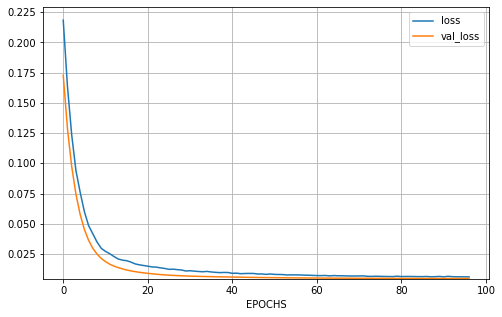

In [47]:
#plot the loss learning curve
nn_plot_learning_curve(history)

In [48]:
#evaluate model loss metric on the training set
model.evaluate(X_train, y_train)

118/118 [==============================] - 0s 2ms/step - loss: 0.0057


0.0057127512991428375

In [49]:
#evaluate model loss metric on the Test set
model.evaluate(X_test, y_test)

30/30 [==============================] - 0s 2ms/step - loss: 0.0041


0.004065563902258873

In [50]:
#predict the Training data set based on SCALED values
y_pred = model.predict(X_train)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_train)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('RMSE: {:,.2f}'.format( rmse ) )

RMSE: 7.52


In [51]:
#predict the test data set based on SC4.ALED values
y_pred = model.predict(X_test)

#scale predicted and actuals
pred = yscaler.inverse_transform( y_pred )
actual = yscaler.inverse_transform(y_test)

#calculate the Root Mean Squared Error using the scaled values
rmse = mean_squared_error(pred,actual,squared=False)
print('RMSE: {:,.2f}'.format( rmse ) )

RMSE: 6.34


In [52]:
#look at 3 items in the Test set to see how they performed
pred[0:3], actual[0:3]

(array([[4.2071095],
        [4.524894 ],
        [7.6063523]], dtype=float32),
 array([[4.948],
        [2.972],
        [4.448]]))

In [53]:
#print using format
for x in range(0,3):
    print( "Prediction {:10,.2f}  ---  Actual {:10,.2f}".format( float(pred[x:x+1]), float(actual[x:x+1]) ) )

Prediction       4.21  ---  Actual       4.95
Prediction       4.52  ---  Actual       2.97
Prediction       7.61  ---  Actual       4.45


In [54]:
set_config(display='diagram')
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  MinMaxScaler())]),
                                 ['BBPwr', 'EnergyIntensity_Sales',
                                  'WasteGenerated_Sales',
                                  'CO2EmissionsPerSales', 'PercentWmnBoard',
                                  'Days2Maturity']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['BBG_Composite'])])